1. Podzielić zbiór na ciąg trenujący i uczący w proporcjach: 50000, 10000 (domyślne wartości w przypadku wykorzystania funkcji bibliotecznej  z pakietu tensorflow.keras.datasets.cifar10.load_data()

2. Zwizualizować 10-25 przykładów ze zbioru

3. Wytrenować autoenkoder w wykorzystaniem warstw splotowych
- warstwa kodująca powinna składać się z nie więcej niż  512 neuronów.
- funkcja straty: błąd średniokowadratowy, optimizer SGD
- liczba epok uczenia: 100, batch_size= 1024

4. Zwizualizować 10-25 przykładów  obraz wejściowy - rekonstrukcja

5. Zbudować prosty klasyfikator wykorzystujący:
 - warstwę enkodującą do transformacji wejścia do wektora (ta warstwa nie będzie zmieniana podczas uczenia)
- dwie warstwy gęste: ostatnia z funkcją aktywacji softmax
- optimizer SGD, funkcja straty: CategoricalCrossentropy

6. Zbadać metrykę accuracy na zbiorze testowym  (ile obrazów zostało poprawnie zaklasyfikowanych)

In [ ]:
from tensorflow.keras import datasets, layers, models, utils, optimizers, losses
import matplotlib.pyplot as plt

In [ ]:
# 1. Podzielić zbiór na ciąg trenujący i uczący w proporcjach: 50000, 10000
# (domyślne wartości w przypadku wykorzystania funkcji bibliotecznej z pakietu
# tensorflow.keras.datasets.cifar10.load_data()
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
assert train_images.shape == (50000, 32, 32, 3)
assert test_images.shape == (10000, 32, 32, 3)
assert train_labels.shape == (50000, 1)
assert test_labels.shape == (10000, 1)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


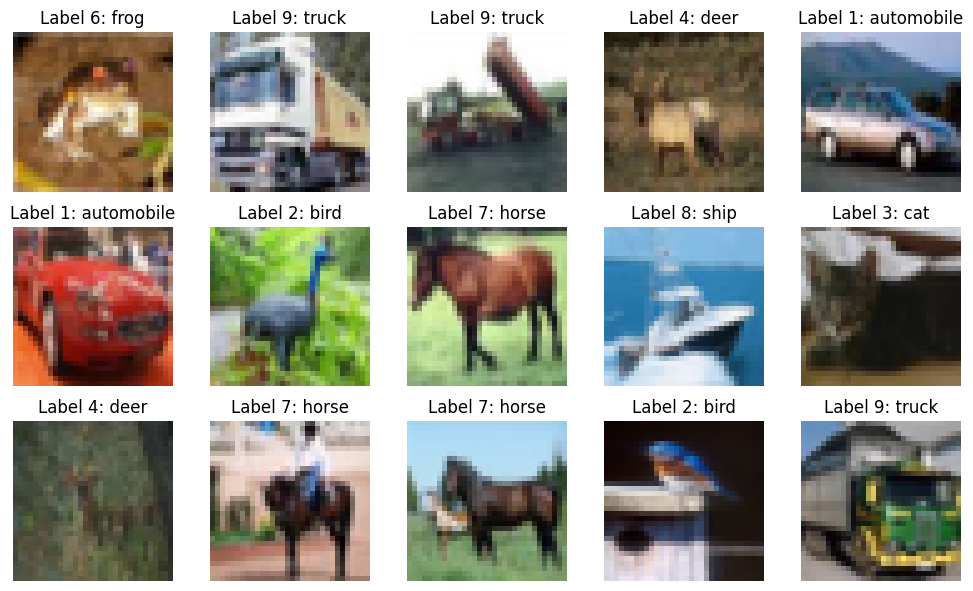

In [ ]:
# 2. Zwizualizować 10-25 przykładów ze zbioru

images_to_print = 15

ordered_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

fig, axes = plt.subplots(int(images_to_print / 5), 5, figsize=(10, 2 * (images_to_print / 5)))
axes = axes.ravel()

for i in range(images_to_print):
    axes[i].imshow(train_images[i])
    axes[i].axis('off')
    axes[i].set_title(f"Label {train_labels[i][0]}: {ordered_labels[train_labels[i][0]]}")

plt.tight_layout()
plt.show()

In [ ]:
# 3. Wytrenować autoenkoder w wykorzystaniem warstw splotowych
# - warstwa kodująca powinna składać się z nie więcej niż 512 neuronów.
# - funkcja straty: błąd średniokowadratowy, optimizer SGD
# - liczba epok uczenia: 100, batch_size= 1024

# Normalizacja obrazow
train_images_normalized = train_images / 255.0
test_images_normalized = test_images / 255.0

# Model encodera
encoder = models.Sequential([
    layers.InputLayer(shape=(32, 32, 3)),
    layers.Reshape((32, 32, 3)),
    layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
    layers.MaxPool2D(pool_size=2),
    layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
    layers.MaxPool2D(pool_size=2),
    layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu"),
    layers.MaxPool2D(pool_size=2)
])

# Decoder Model
decoder = models.Sequential([
    layers.InputLayer(shape=(4, 4, 64)),
    layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="VALID", activation="selu"),
    layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME", activation="selu"),
    layers.Conv2DTranspose(3, kernel_size=3, strides=2, padding="SAME", activation="sigmoid"),
    layers.Cropping2D(((2, 2), (2, 2))),  # Przycięcie obrazu do 32x32, jest 36x36 bo SAME dodaje dla skalowania
    layers.Reshape((32, 32, 3))
])

encoder.summary()
decoder.summary()

# Utworzenie autoencodera
autoencoder = models.Sequential([encoder, decoder])

# Uruchomienie modelu autoencodera
autoencoder.compile(loss='mse', optimizer=optimizers.SGD(learning_rate=1.0))

# Uruchomienie uczenia autoenkodera
history = autoencoder.fit(
    train_images_normalized,
    train_images_normalized,
    epochs=100,
    batch_size=1024,
    validation_data=(test_images_normalized, test_images_normalized),
)

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ reshape_6 (Reshape)                  │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 32, 32, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 16, 16, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 16, 16, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 8, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 8, 8, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 4, 4, 64)            │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,584 (92.12 KB)

 Trainable params: 23,584 (92.12 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_transpose_9 (Conv2DTranspose) │ (None, 9, 9, 32)            │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_10                  │ (None, 18, 18, 16)          │           4,624 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_11                  │ (None, 36, 36, 3)           │             435 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cropping2d_3 (Cropping2D)            │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_7 (Reshape)                  │ (None, 32, 32, 3)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,523 (91.89 KB)

 Trainable params: 23,523 (91.89 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - loss: 0.0636 - val_loss: 0.0623
Epoch 2/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 0.0619 - val_loss: 0.0600
Epoch 3/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0580 - val_loss: 0.0415
Epoch 4/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0411 - val_loss: 0.0306
Epoch 5/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0292 - val_loss: 0.0259
Epoch 6/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0255 - val_loss: 0.0240
Epoch 7/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0236 - val_loss: 0.0228
Epoch 8/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0225 - val_loss: 0.0214
Epoch 9/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0213 - val_loss: 0.0213
Epoch 10/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0209 - val_loss: 0.0204
Epoch 11/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0202 - val_loss: 0.0196
Epoch 12/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


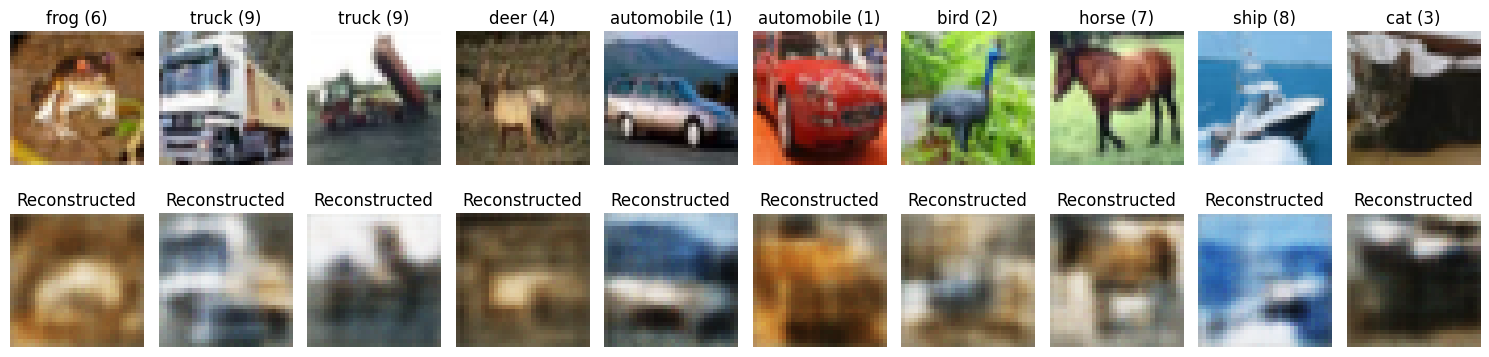

In [ ]:
# 4. Zwizualizować 10-25 przykładów  obraz wejściowy - rekonstrukcja

images_to_compare = 10

reconstructed_images = autoencoder.predict(train_images_normalized[:images_to_compare])

fig, axes = plt.subplots(2, images_to_compare, figsize=(15, 4))
axes = axes.ravel()

for i in range(images_to_compare):
    axes[i].imshow(train_images[i])
    axes[i].axis('off')
    axes[i].set_title(f"{ordered_labels[train_labels[i][0]]} ({train_labels[i][0]})")

    axes[i + images_to_compare].imshow(reconstructed_images[i])
    axes[i + images_to_compare].axis('off')
    axes[i + images_to_compare].set_title(f"Reconstructed")

plt.tight_layout()
plt.show()

In [ ]:
# 5. Zbudować prosty klasyfikator wykorzystujący:
# - warstwę enkodującą do transformacji wejścia do wektora (ta warstwa nie będzie zmieniana podczas uczenia)
# - dwie warstwy gęste: ostatnia z funkcją aktywacji softmax
# - optimizer SGD, funkcja straty: CategoricalCrossentropy

# Przygotowanie etykiet w formacie one-hot encoding
num_classes = 10
train_labels_one_hot = utils.to_categorical(train_labels, num_classes=num_classes)
test_labels_one_hot = utils.to_categorical(test_labels, num_classes=num_classes)
encoder.trainable = False

# Model klasyfikatora
classifier = models.Sequential([
    encoder,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

# Kompilacja modelu
classifier.compile(
    optimizer=optimizers.SGD(learning_rate=0.1),
    loss=losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

# Trenowanie modelu klasyfikatora
history_classifier = classifier.fit(
    train_images_normalized,
    train_labels_one_hot,
    epochs=20,
    batch_size=1024,
    validation_data=(test_images_normalized, test_labels_one_hot)
)

Epoch 1/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.2687 - loss: 2.0351 - val_accuracy: 0.4060 - val_loss: 1.7003
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4179 - loss: 1.6687 - val_accuracy: 0.4378 - val_loss: 1.6011
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4527 - loss: 1.5655 - val_accuracy: 0.4680 - val_loss: 1.5188
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4780 - loss: 1.4997 - val_accuracy: 0.4780 - val_loss: 1.4800
Epoch 5/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4920 - loss: 1.4540 - val_accuracy: 0.4942 - val_loss: 1.4415
Epoch 6/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5042 - loss: 1.4222 - val_accuracy: 0.5009 - val_loss: 1.4166
Epoch 7/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5102 - loss: 1.3950 - val_accuracy: 0.5110 - val_loss: 1.3950
Epoch 8/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5279 - loss: 1.3661 - val_accuracy: 0.5157 - v

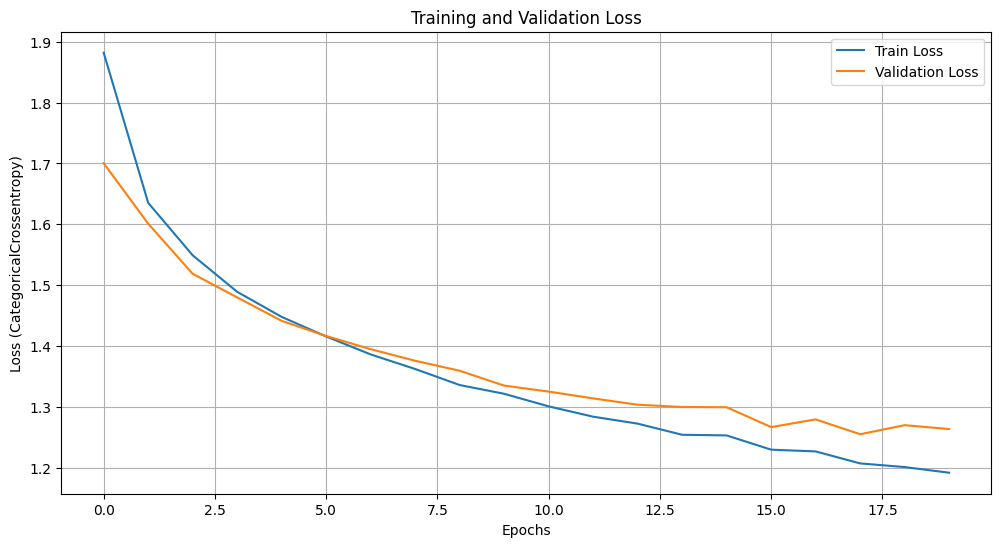

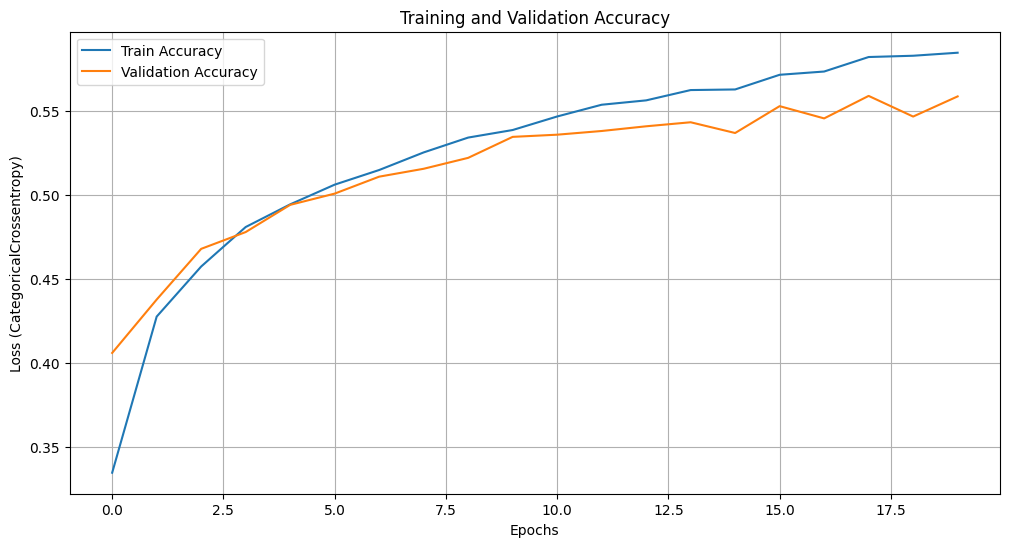

313/313 - 1s - 3ms/step - accuracy: 0.5588 - loss: 1.2638


[1.2638298273086548, 0.5587999820709229]

In [ ]:
# 6. Zbadać metrykę accuracy na zbiorze testowym  (ile obrazów zostało poprawnie zaklasyfikowanych)

plt.figure(figsize=(12, 6))

plt.plot(history_classifier.history['loss'], label='Train Loss')
plt.plot(history_classifier.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (CategoricalCrossentropy)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))

plt.plot(history_classifier.history['accuracy'], label='Train Accuracy')
plt.plot(history_classifier.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss (CategoricalCrossentropy)')
plt.legend()
plt.grid(True)
plt.show()

classifier.evaluate(test_images_normalized, test_labels_one_hot, verbose=2)

# Wnioski:

# Krzywa uczenia się maleje wraz z kolejnymi epokami:
# - Mocny spadek przy pierwszych 5 epokach
# - Średni spadek w pozostałych epokach

# Krzywa walidacyjna oscyluje wokół krzywej uczenia
# Miejscami ma większą wartość niż krzywa uczenia, istnieje ryzyko przeuczenia

# Dokładność dla danych treningowych rośnie wraz z kolejnymi epokami
# - Duży wzrost przy pierwszych kilku epokach
# - Średni wzrosty w pozostałych epokach

# Dokładność dla danych testowych nieznacznie przekracza dokładność dla danych treningowych

# Dokładność wyniosła 0.5067, co jest dobrym wynikiem

In [ ]:
!python --version

Python 3.10.12
